In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pdb

from cam_calibrator import CameraCalibrator

In [2]:
cc = CameraCalibrator()

cal_img_path = './webcam_12'  # Location of calibration images
name = 'webcam'               # Name of the camera
n_corners = [7, 9]            # Corner grid dimensions
square_length = 0.0205        # Chessboard square length in meters

display_flag = False
cc.loadImages(cal_img_path, name, n_corners, square_length, display_flag)

u_meas, v_meas = cc.getMeasuredPixImageCoord()

*** Added sample 1, p_x = 0.516, p_y = 0.498, p_size = 0.370, skew = 0.517
*** Added sample 2, p_x = 0.565, p_y = 0.466, p_size = 0.554, skew = 0.210
*** Added sample 3, p_x = 0.352, p_y = 0.516, p_size = 0.472, skew = 0.020
*** Added sample 4, p_x = 0.747, p_y = 0.302, p_size = 0.292, skew = 0.073
*** Added sample 5, p_x = 0.564, p_y = 0.556, p_size = 0.386, skew = 0.874
*** Added sample 6, p_x = 0.473, p_y = 0.431, p_size = 0.327, skew = 0.433
*** Added sample 7, p_x = 0.461, p_y = 0.633, p_size = 0.447, skew = 0.464
*** Added sample 8, p_x = 0.500, p_y = 0.350, p_size = 0.466, skew = 0.309
*** Added sample 9, p_x = 0.566, p_y = 0.512, p_size = 0.397, skew = 0.072
*** Added sample 10, p_x = 0.505, p_y = 0.474, p_size = 0.467, skew = 0.012
*** Added sample 11, p_x = 0.490, p_y = 0.553, p_size = 0.474, skew = 0.169
*** Added sample 12, p_x = 0.578, p_y = 0.517, p_size = 0.420, skew = 0.270


In [3]:
def genCornerCoordinates(cc, u_meas, v_meas):
    # generate world coordinates (X,Y) for every corner in the chessboard.
    # the ordering must correspond exactly to the order in (u_meas,v_meas)
    #X = [(self.n_corners_x - 1) * self.d_square -self.d_square*float(i%self.n_corners_x) for i in range(len(u_meas))] # from bottom right corner 
    #Y = [self.d_square*float(i/self.n_corners_x) for i in range(len(v_meas))]

    # origin = top left, x increases to the right, y increases down
    X = [cc.d_square*float(i%cc.n_corners_x) for i in range(len(u_meas[0]))] # from bottom right corner 
    Y = [cc.d_square*float(i/cc.n_corners_x) for i in range(len(v_meas[0]))]

    return X, Y

In [4]:
X, Y = genCornerCoordinates(cc, u_meas, v_meas)

In [5]:
def estimateHomography(cc, u_meas, v_meas, X, Y):
    # form matrix L
    M = np.vstack((X, Y, [1.0 for _ in range(len(X))]))

    u = np.dot(np.array([u_meas]).T, np.ones([1,3]))
    v = np.dot(np.array([v_meas]).T, np.ones([1,3]))
    uM = u*M.T
    vM = v*M.T

    L1 = np.hstack((M.T, np.zeros(M.T.shape), -uM))
    L2 = np.hstack((np.zeros(M.T.shape), M.T, -vM))
    L = np.vstack((L1, L2))

    # SVD
    U,S,V  = np.linalg.svd(L,full_matrices=False)
    h = V[-1] # eignevector associated with smallest singular value in S, which is the last vector in V
    H = h.reshape(3,3)

    return H

In [6]:
H_dict = {}
for i in range(len(u_meas)):
    H_dict[i] = estimateHomography(cc, u_meas[i], v_meas[i], X, Y)

In [7]:
def getCameraIntrinsics(cc, H):
    V = np.zeros([1,6])

    for _,Hmat in H.iteritems():
        h1 = Hmat.T[0]
        h2 = Hmat.T[1]
        h3 = Hmat.T[2]

        v_11 = [h1[0]*h1[0], h1[0]*h1[1]+h1[1]*h1[0], h1[1]*h1[1], h1[2]*h1[0]+h1[0]*h1[2], h1[2]*h1[1]+h1[1]*h1[2], h1[2]*h1[2]]
        v_22 = [h2[0]*h2[0], h2[0]*h2[1]+h2[1]*h2[0], h2[1]*h2[1], h2[2]*h2[0]+h2[0]*h2[2], h2[2]*h2[1]+h2[1]*h2[2], h2[2]*h2[2]]
        v_12 = [h1[0]*h2[0], h1[0]*h2[1]+h1[1]*h2[0], h1[1]*h2[1], h1[2]*h2[0]+h1[0]*h2[2], h1[2]*h2[1]+h1[1]*h2[2], h1[2]*h2[2]]

        if V.shape[0] < 2:
            V = np.vstack((np.array(v_12), np.array(v_11)-np.array(v_22)))
        else:
            V2 = np.vstack((np.array(v_12), np.array(v_11)-np.array(v_22)))
            V = np.vstack((V,V2))

    U,S,V_ = np.linalg.svd(V,full_matrices=False)
    b = V_[-1]

    B = np.array([
        [b[0], b[1], b[3]],
        [b[1], b[2], b[4]],
        [b[3], b[4], b[5]]
    ])

    v0 = (B[0,1]*B[0,2] - B[0,0]*B[1,2])/(B[0,0]*B[1,1] - B[0,1]**2)
    lam = B[2,2] - (B[0,2]**2 + v0*(B[0,1]*B[0,2] - B[0,0]*B[1,2]))/B[0,0]
    alpha = np.sqrt(lam/B[0,0])
    beta = np.sqrt(lam*B[0,0] / (B[0,0]*B[1,1] - B[0,1]**2))
    gamma = -B[0,1]* alpha**2 * beta / lam
    u0 = gamma*v0/alpha - B[0,2]*alpha**2 / lam

    A = np.array([
        [alpha, gamma, u0],
        [0,     beta,  v0],
        [0,     0,     1]
    ])

    print "#########"
    print A

    #pdb.set_trace()

    return A

In [8]:
A = getCameraIntrinsics(cc, H_dict)

#########
[[  1.31777815e+03   4.00901096e+01   4.12505964e+02]
 [  0.00000000e+00   1.22400000e+03   2.93599285e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]


In [9]:
def getExtrinsics(cc, H, A):

    A_inv = np.linalg.inv(A)
    lam = 1/np.linalg.norm(A_inv.dot(H.T[0]))
    r1 = lam*A_inv.dot(H.T[0])
    r2 = lam*A_inv.dot(H.T[1])
    r3 = np.cross(r1,r2)
    t = lam * A_inv.dot(H.T[2])
    R_g = np.vstack((r1,r2,r3)).T

    U,S,V = np.linalg.svd(R_g,full_matrices=False)
    R = U.dot(V)

    return R, t

In [10]:
R_dict = {}
t_dict = {}
for i in range(len(u_meas)):
    R_dict[i], t_dict[i] = getExtrinsics(cc, H_dict[i], A)

In [11]:
def transformWorld2NormImageUndist(cc, X, Y, Z, R, t):
    """
    Note: The transformation functions should only process one chessboard at a time!
    This means X, Y, Z, R, t should be individual arrays
    """

    R_t = np.hstack((R,np.array([t]).T))
    XYZ_W = np.vstack((X,Y,Z,np.ones(X.shape))).T # homogeneous world frame coordinates
    XYZ_C = R_t.dot(XYZ_W.T) # camera frame coordinates
    #xyz_c = A.dot(R_t.dot(XYZ_W.T))
    x = XYZ_C[0]/XYZ_C[2]
    y = XYZ_C[1]/XYZ_C[2]

    return x, y

In [12]:
X_big = np.repeat(np.array([X]),cc.n_chessboards,axis=0)
Y_big = np.repeat(np.array([Y]),cc.n_chessboards,axis=0)
Z = np.zeros(X_big[0].shape)

In [13]:
def transformWorld2PixImageUndist(cc, X, Y, Z, R, t, A):
    R_t = np.hstack((R,np.array([t]).T))
    #XYZ_W = np.vstack((X,Y,Z,[1 for _ in X])).T # homogeneous world frame coordinates
    XYZ_W = np.vstack((X,Y,Z,np.ones(X.shape))).T

    xyz_c = A.dot(R_t.dot(XYZ_W.T))
    u = xyz_c[0]/xyz_c[2]
    v = xyz_c[1]/xyz_c[2]

    return u, v

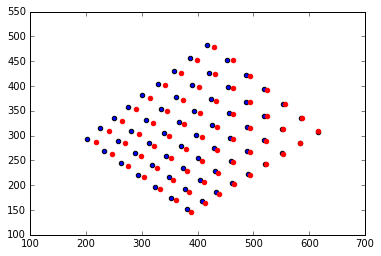

In [14]:
u, v = transformWorld2PixImageUndist(cc, X_big[0], Y_big[0], Z, R_dict[0], t_dict[0], A)
plt.scatter(u,v)
plt.hold=True
plt.scatter(u_meas[0],v_meas[0],color="red")
#plt.xlim([0,700])
#plt.ylim([0,600])
plt.show()

In [15]:
    def transformWorld2NormImageDist(self, X, Y, Z, R, t, k):
        R_t = np.hstack((R,np.array([t]).T))
        XYZ_W = np.vstack((X,Y,Z,np.ones(X.shape))).T # homogeneous world frame coordinates
        XYZ_C = R_t.dot(XYZ_W.T) # camera frame coordinates

        x = XYZ_C[0]/XYZ_C[2]
        y = XYZ_C[1]/XYZ_C[2]

        x_br = x + x*(k[0]*(x**2 + y**2) + k[1]*(x**2 + y**2)**2)
        y_br = y + y*(k[0]*(x**2 + y**2) + k[1]*(x**2 + y**2)**2)

        return x_br, y_br

In [16]:
    def transformWorld2PixImageDist(self, X, Y, Z, R, t, A, k):
        R_t = np.hstack((R,np.array([t]).T))
        #XYZ_W = np.vstack((X,Y,Z,[1 for _ in X])).T # homogeneous world frame coordinates
        XYZ_W = np.vstack((X,Y,Z,np.ones(X.shape))).T

        XYZ_C = R_t.dot(XYZ_W.T) # camera frame coordinates

        # normalize
        XYZ_C[0] = XYZ_C[0]/XYZ_C[2]
        XYZ_C[1] = XYZ_C[1]/XYZ_C[2]
        XYZ_C[2] = XYZ_C[2]/XYZ_C[2]

        x = XYZ_C[0]
        y = XYZ_C[1]

        uv = A.dot(XYZ_C)

        u = uv[0]
        v = uv[1]

        u_0 = A[0,2]
        v_0 = A[1,2]

        u_br = u + (u - u_0)*(k[0]*(x**2 + y**2) + k[1]*(x**2 + y**2)**2)
        v_br = v + (v - v_0)*(k[0]*(x**2 + y**2) + k[1]*(x**2 + y**2)**2)

        return u_br, v_br

In [17]:
k = np.array([1,1])

In [18]:
u_br, v_br = transformWorld2PixImageDist(cc, X_big[0], Y_big[0], Z, R_dict[0], t_dict[0], A, k)

In [19]:
    def estimateLensDistortion(self, u_meas, v_meas, X, Y, R, t, A):
        u_0 = A[0,2]
        v_0 = A[1,2]

        Z = np.zeros(X[0].shape)

        D = np.zeros([2*len(u_meas[0]),2])
        d = np.zeros([2*len(u_meas[0]),1])

        for i in range(len(u_meas)):
            x,y = transformWorld2NormImageUndist(cc, X[i], Y[i], Z, R[i], t[i])
            u,v = transformWorld2PixImageUndist(cc, X[i], Y[i], Z, R[i], t[i], A)

            if i == 1:
                D_1 = np.vstack(((u - u_0) * (x**2 + y**2), (u - u_0) * (x**2 + y**2)**2)).T
                D_2 = np.vstack(((v - v_0) * (x**2 + y**2), (v - v_0) * (x**2 + y**2)**2)).T
                D = np.vstack((D_1,D_2))
                d = np.hstack(([u_meas[i]-u], [v_meas[i]-v])).T

            else:
                D_1 = np.vstack(((u - u_0) * (x**2 + y**2), (u - u_0) * (x**2 + y**2)**2)).T
                D_2 = np.vstack(((v - v_0) * (x**2 + y**2), (v - v_0) * (x**2 + y**2)**2)).T
                # stack with previous matrices
                D = np.vstack((D,D_1,D_2))
                d = np.vstack((d, np.hstack(([u_meas[i]-u], [v_meas[i]-v])).T))

        k = np.linalg.inv(D.T.dot(D)).dot(D.T).dot(d)

        return k

In [20]:
estimateLensDistortion(cc, u_meas, v_meas, X_big, Y_big, R_dict, t_dict, A)

array([[ -5.86167302e-03],
       [ -5.90494967e+00]])

In [21]:
x, y = transformWorld2NormImageUndist(cc, X_big[0], Y_big[0], Z, R_dict[0], t_dict[0])


In [ ]:
D_1 = np.vstack(((u - u_0) * (x**2 + y**2), (u - u_0) * (x**2 + y**2)**2)).T
D_2 = np.vstack(((v - v_0) * (x**2 + y**2), (v - v_0) * (x**2 + y**2)**2)).T
D = np.vstack((D_1,D_2))

d = np.hstack(([u_br-u], [v_br-v])).T

In [24]:
u_0 = A[0,2]
v_0 = A[1,2]

Z = np.zeros(X_big[0].shape)

for i in range(len(u_meas)):
    x,y = transformWorld2NormImageUndist(cc, X_big[i], Y_big[i], Z, R_dict[i], t_dict[i])
    u,v = transformWorld2PixImageUndist(cc, X_big[i], Y_big[i], Z, R_dict[i], t_dict[i], A)
    
    if i == 0:
        D_1 = np.vstack(((u - u_0) * (x**2 + y**2), (u - u_0) * (x**2 + y**2)**2)).T
        D_2 = np.vstack(((v - v_0) * (x**2 + y**2), (v - v_0) * (x**2 + y**2)**2)).T
        D = np.vstack((D_1,D_2))
        d = np.hstack(([u_meas[i]-u], [v_meas[i]-v])).T
        
    else:
        D_1 = np.vstack(((u - u_0) * (x**2 + y**2), (u - u_0) * (x**2 + y**2)**2)).T
        D_2 = np.vstack(((v - v_0) * (x**2 + y**2), (v - v_0) * (x**2 + y**2)**2)).T
        # stack with previous matrices
        D = np.vstack((D,D_1,D_2))
        d = np.vstack((d, np.hstack(([u_meas[i]-u], [v_meas[i]-v])).T))
        
    print i, D.shape

0 (126, 2)
1 (252, 2)
2 (378, 2)
3 (504, 2)
4 (630, 2)
5 (756, 2)
6 (882, 2)
7 (1008, 2)
8 (1134, 2)
9 (1260, 2)
10 (1386, 2)
11 (1512, 2)


In [42]:
d.shape

(1512, 1)

In [38]:
#k_guess = np.linalg.inv(D.T.dot(D)).dot(D.T).dot(d)
k_guess = np.dot(np.linalg.pinv(D),d)
k_guess

array([[-0.16236883],
       [-2.57257792]])

In [28]:
np.hstack([k_guess.T,0,0])

ValueError: all the input arrays must have same number of dimensions

In [30]:
np.zeros(2).shape

(2,)

In [46]:
k_guess = k_guess.reshape((2,))

In [47]:
k_guess

array([-0.16236883, -2.57257792])